In [1]:
# Description: Plot Figures 10 and 11 (Nonlinear Internal Wave packet example).
# Author:      André Palóczy
# E-mail:      paloczy@gmail.com
# Date:        December/2020

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from xarray import open_dataset, DataArray
from cmocean.cm import balance
from pandas import Series, Timedelta, Timestamp
from dewaveADCP.utils import fourfilt
from dewaveADCP.beam2earth import janus2earth5
from dewaveADCP.AdaptiveFiltering import bvelAF
from datetime import datetime, timedelta

In [3]:
def bvar_nomean(b):
    return b**2

def rot_uwvw(uw, vw, phi1):
    Sphi1, Cphi1 = sind(phi1)[np.newaxis,...], cosd(phi1)[np.newaxis,...]
    uwr = uw*np.nan
    vwr = uwr.copy()

    uwr = +uw*Cphi1 + vw*Sphi1
    vwr = -uw*Sphi1 + vw*Cphi1

    return uwr, vwr

def sind(x):
    return np.sin(x*np.pi/180)

def cosd(x):
    return np.cos(x*np.pi/180)

In [4]:
plt.close('all')
theta = 25
vmau = 0.15 # [m/s]
vma = 1e-3 # [m2/s2].

NO_TILT_CORR = False

dts = 1
Tmin = 100# for finding the lags.

headf = "../../data_reproduce_figs/"
f = "OC25SA-Ad1beam_NLIWfig.nc"
ds = open_dataset(headf+f)

In [5]:
finT = "OC25SA-T.nc"
T = open_dataset(headf+finT)['T']
T = T.interpolate_na(dim='z').interpolate_na(dim='t')
T['z'] = 25 - T['z']

T['t'] = T['t'] - Timedelta("2.5 min")

In [6]:
ds = ds.interpolate_na(dim='t').interpolate_na(dim='z')
b1, b2, b3, b4, b5 = ds['b1'].T, ds['b2'].T, ds['b3'].T, ds['b4'].T, ds['b5'].T
rj = ds['r'].values
b1lp, b2lp, b3lp, b4lp, b5lp = b1.copy(), b2.copy(), b3.copy(), b4.copy(), b5.copy()
head, ptch, roll = ds['hdng'].values, ds['ptch'].values, ds['roll'].values
t, z = ds['t'].values, ds['z'].values
nz, nt = b1.shape
Tmax = nt*dts*2
d2r = np.pi/180
Sth = np.sin(theta*d2r)
Cth = np.cos(theta*d2r)

In [7]:
coords, dims = b1.coords, b1.dims
kwAF = dict(sep=4, Lw=8, max_badfrac=0.05, verbose=False)
b1dw = bvelAF(b1.values, **kwAF)
b2dw = bvelAF(b2.values, **kwAF)
b3dw = bvelAF(b3.values, **kwAF)
b4dw = bvelAF(b4.values, **kwAF)
b5dw = bvelAF(b5.values, **kwAF)

b1dw = DataArray(b1dw, coords=coords, dims=dims)
b2dw = DataArray(b2dw, coords=coords, dims=dims)
b3dw = DataArray(b3dw, coords=coords, dims=dims)
b4dw = DataArray(b4dw, coords=coords, dims=dims)
b5dw = DataArray(b5dw, coords=coords, dims=dims)

In [8]:
for k in range(nz):
    #print(str(k+1)+" / "+str(nz))
    b1lp[k,:] = fourfilt(b1.values[k,:], dts, Tmax, Tmin)
    b2lp[k,:] = fourfilt(b2.values[k,:], dts, Tmax, Tmin)
    b3lp[k,:] = fourfilt(b3.values[k,:], dts, Tmax, Tmin)
    b4lp[k,:] = fourfilt(b4.values[k,:], dts, Tmax, Tmin)
    b5lp[k,:] = fourfilt(b5.values[k,:], dts, Tmax, Tmin)


b1 = DataArray(b1, coords=coords, dims=dims)
b2 = DataArray(b2, coords=coords, dims=dims)
b3 = DataArray(b3, coords=coords, dims=dims)
b4 = DataArray(b4, coords=coords, dims=dims)
b5 = DataArray(b5, coords=coords, dims=dims)

In [9]:
b1 = b1lp
b2 = b2lp
b3 = b3lp
b4 = b4lp
b5 = b5lp

fzs = range(0, nz, 10)
# nblks = 10
# maxlag = 200
# fig, ax = plt.subplots()
# for fz in fzs:
#     print("%d / %d"%(fz+1, nz))
#     l, xc = crosscorr(amp3[fz], amp4[fz], nblks, onesided=False, verbose=False)
#     ff = np.abs(l)<maxlag
#     ax.plot(l[ff], xc[ff], label="bin %d"%fz)
#     print("Max correlation at lag = %d s"%(l[ff][xc[ff].argmax()]))
# ax.legend()
# ax.grid()
# plt.show()


# Finding the lag by inspection of the cross-correlation functions,
# no clean wnough peaks to pick out objectively.
lag = [5, 26, 60, 96, 120]#160#l[xc.argmax()]
# lag = [5, 26, 60, 96]
c = 2*Sth*rj[fzs]/lag

# Then take mean phase speed, and use it to assign lags
# to each height and compute the lagged transformation.
Lag = 2*Sth*rj/np.mean(c) # [s, or # of lags because sampling frequency is 1 Hz].
Lag = np.int32(np.around(Lag))

# beam 3 is pointing ~onshore. Wave arrives at beam 4 first.
b3lg, b4lg = b3.values.copy(), b4.values.copy()
b3dwlg, b4dwlg = b3dw.values.copy(), b4dw.values.copy()
for k in range(nz):
    b3lg[k, :] = b3.isel(dict(z=k)).shift(dict(t=-Lag[k]//2))
    b4lg[k, :] = b4.isel(dict(z=k)).shift(dict(t=Lag[k]//2))
    b3dwlg[k, :] = b3dw.isel(dict(z=k)).shift(dict(t=-Lag[k]//2))
    b4dwlg[k, :] = b4dw.isel(dict(z=k)).shift(dict(t=Lag[k]//2))

b3lg = DataArray(b3lg, coords=coords, dims=dims)
b4lg = DataArray(b4lg, coords=coords, dims=dims)
b3dwlg = DataArray(b3dwlg, coords=coords, dims=dims)
b4dwlg = DataArray(b4dwlg, coords=coords, dims=dims)

# Compare lag-corrected and uncorrected instrument-coordinate vel.
Ve = (b4 - b3)*Sth
Velg = (b4lg - b3lg)*Sth

Text(0.5, 1.0, 'Uncorrected versus lag-corrected time-averaged velocity profile')

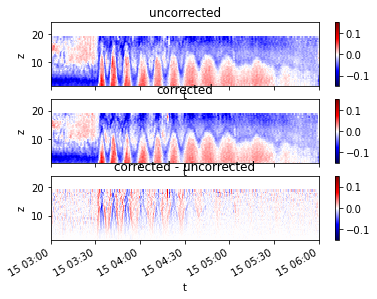

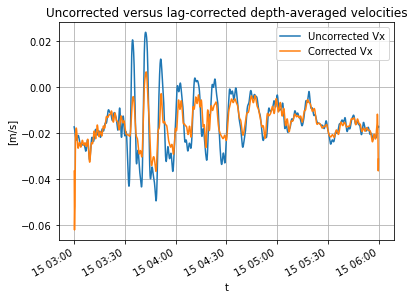

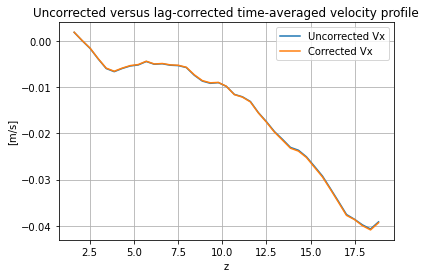

In [10]:
# Compare lag-corrected and uncorrected instrument-coordinate vel.
Ve = (b4 - b3)*Sth
Velg = (b4lg - b3lg)*Sth

vmau2 = 0.15
fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
Ve.plot(ax=ax[0], vmin=-vmau2, vmax=vmau2, cmap=plt.cm.seismic)
Velg.plot(ax=ax[1], vmin=-vmau2, vmax=vmau2, cmap=plt.cm.seismic)
(Velg-Ve).plot(ax=ax[2], vmin=-vmau2, vmax=vmau2, cmap=plt.cm.seismic)
ax[0].set_title("uncorrected")
ax[1].set_title("corrected")
ax[2].set_title("corrected - uncorrected")

fig, ax = plt.subplots()
Ve.mean('z').plot(ax=ax, label="Uncorrected Vx")
Velg.mean('z').plot(ax=ax, label="Corrected Vx")
ax.legend()
ax.grid()
ax.set_ylabel("[m/s]")
ax.set_title("Uncorrected versus lag-corrected depth-averaged velocities")

fig, ax = plt.subplots()
Ve.mean('t').plot(ax=ax, label="Uncorrected Vx")
Velg.mean('t').plot(ax=ax, label="Corrected Vx")
ax.legend()
ax.grid()
ax.set_ylabel("[m/s]")
ax.set_title("Uncorrected versus lag-corrected time-averaged velocity profile")

In [11]:
b3var = (b3 - b3.mean('t'))**2
b4var = (b4 - b4.mean('t'))**2
b3varlg = (b3lg - b3lg.mean('t'))**2
b4varlg = (b4lg - b4lg.mean('t'))**2

if NO_TILT_CORR:
    coeff = 4*Sth*Cth
    uw_uncorr = coeff*(b3var - b4var)
    uw_corr = coeff*(b3varlg - b4varlg)
else:
    b5var = (b5 - b5.mean('t'))**2
    S6C2 = (Sth**6)*(Cth**2)
    S5C1 = (Sth**5)*(Cth)
    S4C2 = (Sth**4)*(Cth**2)
    S4C4 = (Sth*Cth)**4
    S2, C2 = Sth**2, Cth**2

    phi2, phi3 = ptch*d2r, roll*d2r
    b4mb3 = b4var - b3var
    b4pb3 = b4var + b3var
    b4mb3lg = b4varlg - b3varlg
    b4pb3lg = b4varlg + b3varlg
    coeff = -1/(4*S6C2)

    ua, va = (-b1 + b2)*Sth/2, (-b3 + b4)*Sth/2
    uv = (ua - np.nanmean(ua, axis=1, keepdims=True))*(va - np.nanmean(va, axis=1, keepdims=True))
    ua, va = (-b1 + b2)*Sth/2, (-b3lg + b4lg)*Sth/2
    uvlg = (ua - np.nanmean(ua, axis=1, keepdims=True))*(va - np.nanmean(va, axis=1, keepdims=True))

    # Dewey & Stringer (2007)'s equation (133).
    uw_uncorr = coeff*(S5C1*b4mb3 - 2*S4C2*phi3*b4pb3 + 4*S4C4*phi3*b5var + 4*S6C2*phi2*b5var + 4*S6C2*phi3*uv)
    uw_corr = coeff*(S5C1*b4mb3lg - 2*S4C2*phi3*b4pb3lg + 4*S4C4*phi3*b5var + 4*S6C2*phi2*b5var + 4*S6C2*phi3*uvlg)

    moor = f.split('/')[-1].split('-')[0]
    fnoise = headf + "noise_%s.npz"%moor
    dnoise = np.load(fnoise)
    Nb, Nb5 = dnoise["Nb"].flatten()[0], dnoise["Nb5"].flatten()[0]

    phi2ens, phi3ens = np.nanmean(phi2), np.nanmean(phi3)
    biasuw = phi3ens*(Nb5**2 - Nb**2)/S2
    biasvw = phi3ens*(Nb**2 - C2*Nb5**2)/S2 - phi2ens*Nb5**2

    uw_uncorr = uw_uncorr - biasuw
    uw_corr = uw_corr - biasvw

<ipython-input-11-3398cb553499>:26: RuntimeWarning: Mean of empty slice
  uv = (ua - np.nanmean(ua, axis=1, keepdims=True))*(va - np.nanmean(va, axis=1, keepdims=True))
<ipython-input-11-3398cb553499>:28: RuntimeWarning: Mean of empty slice
  uvlg = (ua - np.nanmean(ua, axis=1, keepdims=True))*(va - np.nanmean(va, axis=1, keepdims=True))


Text(0.5, 1.0, "corrected - uncorrected u'w'")

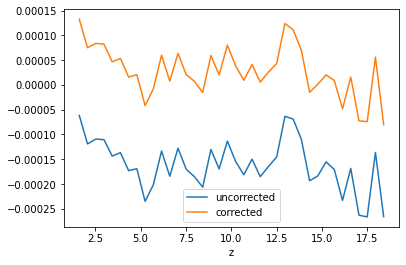

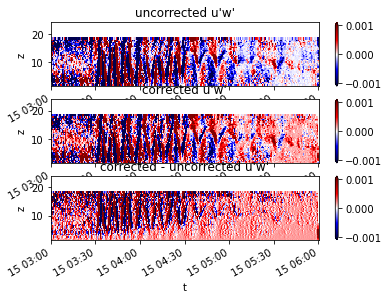

In [12]:
# Compare uncorrected and corrected cross-shelf stresses.
fig, ax = plt.subplots()
uw_uncorr.mean('t').plot(ax=ax, label="uncorrected")
uw_corr.mean('t').plot(ax=ax, label="corrected")
plt.legend()

fig, ax = plt.subplots(nrows=3)
uw_uncorr.resample(dict(t="10 s")).mean('t').plot(ax=ax[0], vmin=-vma, vmax=vma, cmap=plt.cm.seismic)
uw_corr.resample(dict(t="10 s")).mean('t').plot(ax=ax[1], vmin=-vma, vmax=vma, cmap=plt.cm.seismic)
(uw_corr.resample(dict(t="10 s")).mean('t') - uw_uncorr.resample(dict(t="10 s")).mean('t')).plot(ax=ax[2], vmin=-vma, vmax=vma, cmap=plt.cm.seismic)
ax[0].set_title("uncorrected u'w'")
ax[1].set_title("corrected u'w'")
ax[2].set_title("corrected - uncorrected u'w'")

<ipython-input-13-de0721609b09>:9: RuntimeWarning: Mean of empty slice
  arr[np.isnan(arr)] = np.nanmean(arr)
<ipython-input-13-de0721609b09>:12: RuntimeWarning: Mean of empty slice
  arr[np.isnan(arr)] = np.nanmean(arr)


Text(0.5, 1.0, "corrected - uncorrected u'w'")

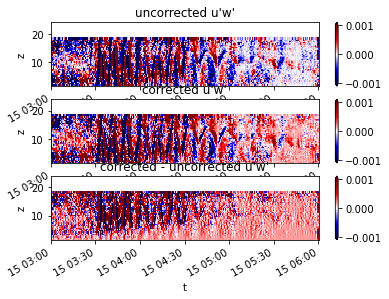

In [13]:
# Plot low-pass filtered versions of the uncorrected and corrected stresses.
uw_uncorr = uw_uncorr.interpolate_na('t')
uw_corr = uw_corr.interpolate_na('t')
uw_uncorrlp = uw_uncorr.copy()
uw_corrlp = uw_corr.copy()
for k in range(nz):
    #print(str(k+1)+" / "+str(nz))
    arr = uw_uncorr[k, :].values
    arr[np.isnan(arr)] = np.nanmean(arr)
    uw_uncorrlp[k,:] = fourfilt(arr, dts, Tmax, Tmin)
    arr = uw_corr[k, :].values
    arr[np.isnan(arr)] = np.nanmean(arr)
    uw_corrlp[k,:] = fourfilt(arr, dts, Tmax, Tmin)

uw_uncorrlp = DataArray(uw_uncorrlp, coords=coords, dims=dims)
uw_corrlp = DataArray(uw_corrlp, coords=coords, dims=dims)

fig, ax = plt.subplots(nrows=3)
uw_uncorrlp.resample(dict(t="10 s")).mean('t').plot(ax=ax[0], vmin=-vma, vmax=vma, cmap=plt.cm.seismic)
uw_corrlp.resample(dict(t="10 s")).mean('t').plot(ax=ax[1], vmin=-vma, vmax=vma, cmap=plt.cm.seismic)
(uw_corrlp.resample(dict(t="10 s")).mean('t') - uw_uncorrlp.resample(dict(t="10 s")).mean('t')).plot(ax=ax[2], vmin=-vma, vmax=vma, cmap=plt.cm.seismic)
ax[0].set_title("uncorrected u'w'")
ax[1].set_title("corrected u'w'")
ax[2].set_title("corrected - uncorrected u'w'")

In [14]:
b1 = b1.values
b2 = b2.values
b3 = b3lg.values
b4 = b4lg.values
b5 = b5.values

In [15]:
u, v, w, w5 = janus2earth5(head, ptch, roll, theta, b1, b2, b3, b4, b5, verbose=False)

In [16]:
# u = (b2 - b1)*Sth
# v = (b4 - b3)*Sth
# w5 = b5

um = np.nanmean(u, axis=1)[:,np.newaxis]
vm = np.nanmean(v, axis=1)[:,np.newaxis]
w5m = np.nanmean(w, axis=1)[:,np.newaxis]

# Direct (Earth-coordinates) covariances.
# u_e'w_e' and v_e'w_e'
# uw = (u - um)*(w5 - w5m)
# vw = (v - vm)*(w5 - w5m)
# uv = (u - um)*(v - vm)

# u_ew_e and v_ew_e
uw = u*w5
vw = v*w5
uv = u*v

# Variance technique covariances.
# b1var, b2var, b3var, b4var = map(bvar, (b1, b2, b3, b4))
b1var, b2var, b3var, b4var = map(bvar_nomean, (b1, b2, b3, b4))
coeff = 1/(4*Sth*Cth)
uwb = (b1var - b2var)*coeff
vwb = (b3var - b4var)*coeff
uwb, vwb = rot_uwvw(uwb, vwb, head)

<ipython-input-16-e26462e062c9>:5: RuntimeWarning: Mean of empty slice
  um = np.nanmean(u, axis=1)[:,np.newaxis]
<ipython-input-16-e26462e062c9>:6: RuntimeWarning: Mean of empty slice
  vm = np.nanmean(v, axis=1)[:,np.newaxis]
<ipython-input-16-e26462e062c9>:7: RuntimeWarning: Mean of empty slice
  w5m = np.nanmean(w, axis=1)[:,np.newaxis]


In [17]:
#===== TURBULENT Reynolds stresses.
b1dwvar = (b1dw - b1dw.mean('t'))**2
b2dwvar = (b2dw - b2dw.mean('t'))**2
b3dwvar = (b3dwlg - b3dwlg.mean('t'))**2
b4dwvar = (b4dwlg - b4dwlg.mean('t'))**2
#=====

uwdwb = (b1dwvar - b2dwvar)*coeff
vwdwb = (b3dwvar - b4dwvar)*coeff
uwdwblp = uwdwb.values.copy()
vwdwblp = vwdwb.values.copy()
for k in range(nz):
    #print(str(k+1)+" / "+str(nz))
    aux = uwdwb.values[k,:]
    aux[np.isnan(aux)] = np.nanmean(aux)
    uwdwblp[k,:] = fourfilt(aux, dts, Tmax, Tmin)
    aux = vwdwb.values[k,:]
    aux[np.isnan(aux)] = np.nanmean(aux)
    vwdwblp[k,:] = fourfilt(aux, dts, Tmax, Tmin)
uwdwb, vwdwb = uwdwblp.copy(), vwdwblp.copy()

uwdwb, vwdwb = rot_uwvw(uwdwb, vwdwb, head)

<ipython-input-17-ab7254b72ec9>:15: RuntimeWarning: Mean of empty slice
  aux[np.isnan(aux)] = np.nanmean(aux)
<ipython-input-17-ab7254b72ec9>:18: RuntimeWarning: Mean of empty slice
  aux[np.isnan(aux)] = np.nanmean(aux)


In [18]:
# rotate to across-/along-isobath coordinates.
ang_isob = -16.72
uw, vw = rot_uwvw(uw, vw, ang_isob)
uwb, vwb = rot_uwvw(uwb, vwb, ang_isob)
uwdwb, vwdwb = rot_uwvw(uwdwb, vwdwb, ang_isob)

In [19]:
dz = np.gradient(z)[:,np.newaxis]
uz = np.gradient(u, axis=0)/dz
vz = np.gradient(v, axis=0)/dz

<ipython-input-20-c1d09a37f867>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs0 = ax[0].pcolormesh(t, z, u, vmin=-vmau, vmax=vmau, cmap=balance)
<ipython-input-20-c1d09a37f867>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs1 = ax[1].pcolormesh(t, z, uw*rho, vmin=-vma, vmax=vma, cmap=balance)
<ipython-input-20-c1d09a37f867>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either spe

Text(0.75, 0.85, '(h)')

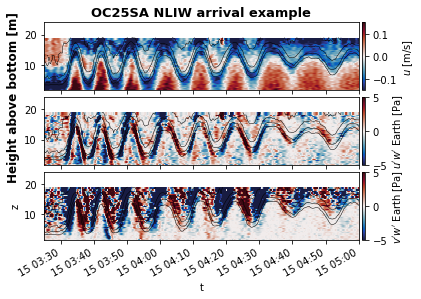

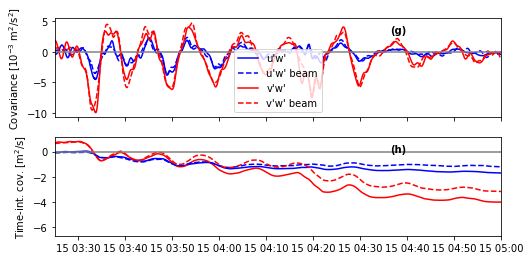

In [20]:
# Plot.
rho = 1024
vma = 5

fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
cs0 = ax[0].pcolormesh(t, z, u, vmin=-vmau, vmax=vmau, cmap=balance)
cs1 = ax[1].pcolormesh(t, z, uw*rho, vmin=-vma, vmax=vma, cmap=balance)
cs2 = ax[2].pcolormesh(t, z, vw*rho, vmin=-vma, vmax=vma, cmap=balance)

kwcb = dict(fraction=0.05, pad=0.01)
cb1 = fig.colorbar(cs0, ax=ax[0], **kwcb)
cb2 = fig.colorbar(cs1, ax=ax[1], **kwcb)
cb3 = fig.colorbar(cs2, ax=ax[2], **kwcb)
cb1.set_label(r"$u$ [m/s]")
cb2.set_label(r"$u'w'$ Earth [Pa]")
cb3.set_label(r"$v'w'$ Earth [Pa]")

tl, tr = "2017-09-15 03:25:00", "2017-09-15 05:00:00"
# ax[0].set_xlim(t[0], t[-1])
ax[0].set_xlim(tl, tr)

# Overlay temperature contours.
Tlevels = np.arange(10, 26, 1)
_ = [T.plot.contour(ax=axn, colors='k', linewidths=0.5, levels=Tlevels) for axn in ax]

ax[0].set_ylabel("")
ax[1].set_ylabel("Height above bottom [m]", fontsize=12, fontweight='black', y=1)
ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[1].xaxis.set_tick_params(rotation=15)
ax[0].set_title("OC25SA NLIW arrival example", fontsize=13, fontweight='black')

fig.subplots_adjust(hspace=0.1)

# figname = "figNLIWstress_upper.png"
# fig.savefig(figname, bbox_inches="tight")

# Depth-averaged and time-integrated stresses.
uvbar = np.nanmean(uv, axis=0)
uwbar = np.nanmean(uw, axis=0)
vwbar = np.nanmean(vw, axis=0)
uwbbar = np.nanmean(uwb, axis=0)
vwbbar = np.nanmean(vwb, axis=0)

xt, yt = 0.75, 0.85
fac = 1e3
figsize = (8, 4)
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=figsize)
ax[0].plot(t, uwbar*fac, 'b', label=r"u'w'")
ax[0].plot(t, uwbbar*fac, 'b--', label=r"u'w' beam")
ax[0].plot(t, vwbar*fac, 'r', label=r"v'w'")
ax[0].plot(t, vwbbar*fac, 'r--', label=r"v'w' beam")
ax[0].axhline(color='gray')
ax[1].plot(t, np.cumsum(uwbar)*dts, 'b')
ax[1].plot(t, np.cumsum(vwbar)*dts, 'r')
ax[1].plot(t, np.cumsum(uwbbar)*dts, 'b--')
ax[1].plot(t, np.cumsum(vwbbar)*dts, 'r--')
ax[0].legend()
ax[0].set_ylabel(r"Covariance [10$^{-3}$ m$^2$/s$^2$]", fontsize=10)
ax[1].set_ylabel(r"Time-int. cov. [m$^2$/s]", fontsize=10)
ax[1].axhline(color='gray')

ax[0].set_xlim(tl, tr)

ax[0].text(xt, yt, "(g)", fontweight="black", transform=ax[0].transAxes)
ax[1].text(xt, yt, "(h)", fontweight="black", transform=ax[1].transAxes)

# fig.savefig("figNLIWstress_lower.png", bbox_inches='tight')

In [21]:
dttotal = np.arange(0, t.size, dts)
dttotal[0] = 1
# Vertically-integrated d(vw)/dz = (vw)_top - (vw)_bot
bsl = 5 # Width of strip to average over top and bottom, in bins.
tsl = 32 # 16 m
H = z[tsl] - z[bsl]

mduwdz_zavg = -(np.nanmean(uw[tsl:, :], axis=0) - np.nanmean(uw[:bsl, :], axis=0))/H
mdvwdz_zavg = -(np.nanmean(vw[tsl:, :], axis=0) - np.nanmean(vw[:bsl, :], axis=0))/H
mduwdz_ztavg = np.cumsum(mduwdz_zavg)*dts/dttotal # [m/ss]
mdvwdz_ztavg = np.cumsum(mdvwdz_zavg)*dts/dttotal

mduwbdz_zavg = -(np.nanmean(uwb[tsl:, :], axis=0) - np.nanmean(uwb[:bsl, :], axis=0))/H
mdvwbdz_zavg = -(np.nanmean(vwb[tsl:, :], axis=0) - np.nanmean(vwb[:bsl, :], axis=0))/H
mduwbdz_ztavg = np.cumsum(mduwbdz_zavg*dts)/dttotal # [m2/s]
mdvwbdz_ztavg = np.cumsum(mdvwbdz_zavg*dts)/dttotal

mduwdwbdz_zavg = -(np.nanmean(uwdwb[tsl:, :], axis=0) - np.nanmean(uwdwb[:bsl, :], axis=0))/H
mdvwdwbdz_zavg = -(np.nanmean(vwdwb[tsl:, :], axis=0) - np.nanmean(vwdwb[:bsl, :], axis=0))/H
mduwdwbdz_ztavg = np.cumsum(mduwdwbdz_zavg*dts)/dttotal # [m2/s]
mdvwdwbdz_ztavg = np.cumsum(mdvwdwbdz_zavg*dts)/dttotal

ubar = np.nanmean(u[bsl:tsl, :], axis=0)
vbar = np.nanmean(v[bsl:tsl, :], axis=0)

Text(0, 1, '[m/s2]')

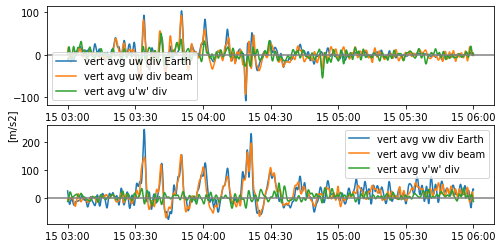

In [22]:
fac = 1e5
figsize = (8, 4)
fig, ax = plt.subplots(nrows=2, sharex=False, figsize=figsize)
ax[0].plot(t, fac*mduwdz_zavg, label="vert avg uw div Earth")
ax[0].plot(t, fac*mduwbdz_zavg, label="vert avg uw div beam")
ax[0].plot(t, fac*mduwdwbdz_zavg, label="vert avg u'w' div")
ax[1].plot(t, fac*mdvwdz_zavg, label="vert avg vw div Earth")
ax[1].plot(t, fac*mdvwbdz_zavg, label="vert avg vw div beam")
ax[1].plot(t, fac*mdvwdwbdz_zavg, label="vert avg v'w' div")
ax[0].axhline(color='gray')
ax[1].axhline(color='gray')
ax[0].legend()
ax[1].legend()
ax[1].set_ylabel("[m/s2]", y=1)

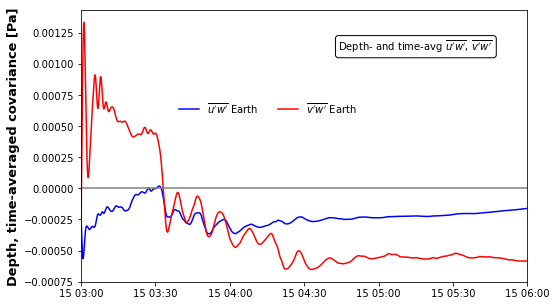

In [23]:
fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(8,5))
ax.plot(t, np.cumsum(uwbar)*dts/dttotal, 'b', label=r"$\overline{u'w'}$ Earth")
ax.plot(t, np.cumsum(vwbar)*dts/dttotal, 'r', label=r"$\overline{v'w'}$ Earth")
# ax.plot(t, np.cumsum(uvbar)*dts/dttotal, 'k', label=r"$\overline{u'v'}$ Earth")
ax.set_ylabel(r"Depth, time-averaged covariance [Pa]", fontsize=13, fontweight='bold')
ax.axhline(color='gray')

xt, yt = 0.75, 0.85
bb = dict(boxstyle='round', ec='k', fc='w')
ax.text(xt, yt, r"Depth- and time-avg $\overline{u'w'}$, $\overline{v'w'}$", transform=ax.transAxes, bbox=bb, ha='center')

tl, tr = "2017-09-15 03:00:00", "2017-09-15 06:00:00"
ax.set_xlim(tl, tr)
ax.legend(bbox_to_anchor=(0.2, 0.7), loc="upper left", frameon=False, ncol=2)

# figname = "figNLIWstress_lower.png"
# fig.savefig(figname, bbox_inches="tight")
plt.show()

<ipython-input-24-31cbcfefeeb6>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs1 = ax1.pcolormesh(t, z, u, vmin=-vmau, vmax=vmau, cmap=balance)
<ipython-input-24-31cbcfefeeb6>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs2 = ax2.pcolormesh(t, z, uwdwb*rho, vmin=-vma, vmax=vma, cmap=balance)
<ipython-input-24-31cbcfefeeb6>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either spec

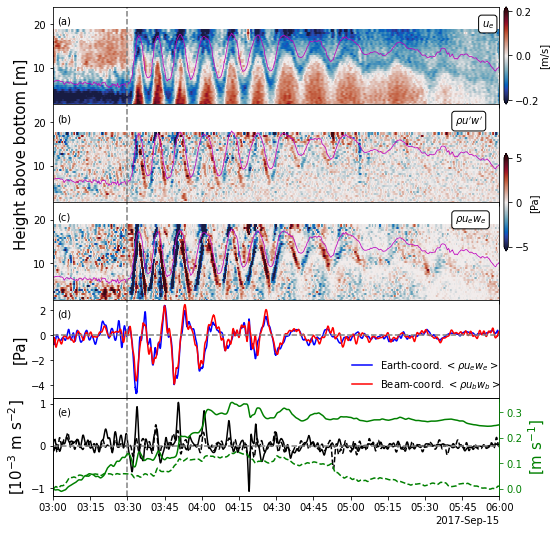

In [24]:
vmau = 0.2
vma = 5
fac = 1e3
fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(8, 9))
fig.subplots_adjust(hspace=0.0)
ax1, ax2, ax3, ax4, ax5 = ax
cs1 = ax1.pcolormesh(t, z, u, vmin=-vmau, vmax=vmau, cmap=balance)
cs2 = ax2.pcolormesh(t, z, uwdwb*rho, vmin=-vma, vmax=vma, cmap=balance)
cs3 = ax3.pcolormesh(t, z, uw*rho, vmin=-vma, vmax=vma, cmap=balance)
ax4.plot(t, uwbar*rho, 'b-', label=r"Earth-coord. $<\rho u_ew_e>$")
ax4.plot(t, uwbbar*rho, 'r-', label=r"Beam-coord. $<\rho u_bw_b>$")
ax4.axhline(color='gray', linestyle='--')
ax4.legend(frameon=False, bbox_to_anchor=(0.65, 0.5))
ax5.plot(t, mduwdz_zavg*fac, 'k-')
ax5.plot(t, mduwdwbdz_zavg*fac, 'k--')
ax5r = ax5.twinx()
ax5r.plot(t, np.cumsum(mduwdz_zavg)*dts, 'g')
mduwdwbdz_zavg0 = mduwdwbdz_zavg.copy()
mduwdwbdz_zavg0[np.isnan(mduwdwbdz_zavg0)] = 0
ax5r.plot(t, np.cumsum(mduwdwbdz_zavg0)*dts, 'g--')
ax5.axhline(color='gray', linestyle='--')
ax5.set_xlim(tl, tr)

ax5r.set_ylabel(r'[m s$^{-1}$]', fontsize=15, color='g')
ax5r.spines['right'].set_color('g')
ax5r.tick_params(axis='y', colors='g')
ax5r.yaxis.set_ticks([0, 0.1, 0.2, 0.3])

ax2.set_ylabel(r"Height above bottom [m]", fontsize=15)
ax4.set_ylabel(r"[Pa]", fontsize=15)
ax5.set_ylabel(r"[$10^{-3}$ m s$^{-2}$]", fontsize=15)
# ax5.text(0.65, 0.15, r"$-[(u_ew_e)_s - (u_ew_e)_b]/h$", fontsize=12, transform=ax5.transAxes)

ax1.contour(T['t'].values, T['z'].values, T.values, levels=[16], colors='m', linewidths=0.75)
ax2.contour(T['t'].values, T['z'].values, T.values, levels=[16], colors='m', linewidths=0.75)
ax3.contour(T['t'].values, T['z'].values, T.values, levels=[16], colors='m', linewidths=0.75)

# Colorbars.
caxx, caxy = 1.01, 0.0
cbaxes = ax1.inset_axes([caxx, caxy, 0.01, 1])
cb = fig.colorbar(mappable=cs1, cax=cbaxes, orientation='vertical', extend='both')
cb.set_ticks([-vmau, 0, vmau])
cb.ax.xaxis.set_tick_params(labelsize=4, rotation=90, pad=-0.5)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
cb.set_label(r"[m/s]", labelpad=-1)

cbaxes = ax2.inset_axes([caxx, caxy-0.5, 0.01, 1])
cb = fig.colorbar(mappable=cs2, cax=cbaxes, orientation='vertical', extend='both')
cb.set_ticks([-vma, 0, vma])
cb.ax.xaxis.set_tick_params(labelsize=4, rotation=90, pad=-0.5)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
cb.set_label(r"[Pa]", labelpad=-1)

xt, yt = 0.01, 0.825
bb = dict(boxstyle='round', ec='k', fc='w')
ax1.text(xt, yt, r"(a)", transform=ax1.transAxes)
ax2.text(xt, yt, r"(b)", transform=ax2.transAxes)
ax3.text(xt, yt, r"(c)", transform=ax3.transAxes)
ax4.text(xt, yt, r"(d)", transform=ax4.transAxes)
ax5.text(xt, yt, r"(e)", transform=ax5.transAxes)
ax1.text(0.96, 0.80, r"$u_e$", transform=ax1.transAxes, bbox=bb)
ax2.text(0.90, 0.80, r"$\rho u'w'$", transform=ax2.transAxes, bbox=bb)
ax3.text(0.90, 0.80, r"$\rho u_ew_e$", transform=ax3.transAxes, bbox=bb)

t_NLIWarrival = Timestamp("2017-09-15 03:30")
ax1.axvline(x=t_NLIWarrival, linestyle='dashed', color='gray')
ax2.axvline(x=t_NLIWarrival, linestyle='dashed', color='gray')
ax3.axvline(x=t_NLIWarrival, linestyle='dashed', color='gray')
ax4.axvline(x=t_NLIWarrival, linestyle='dashed', color='gray')
ax5.axvline(x=t_NLIWarrival, linestyle='dashed', color='gray')


locator = mdates.AutoDateLocator(minticks=8, maxticks=14)
formatter = mdates.ConciseDateFormatter(locator)
ax5.xaxis.set_major_locator(locator)
ax5.xaxis.set_major_formatter(formatter)

In [25]:
fig.savefig("fig10.png", dpi=300, bbox_inches="tight")

Smallest significant Reynolds stress: 0.0690 Pa


<ipython-input-26-fddf838b18c9>:15: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(uw[:, fnliw:], axis=1)*rho, z, 'purple', label=r"$\rho\overline{u_ew_e}$")
<ipython-input-26-fddf838b18c9>:16: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(uwdwb[:, fnliw:], axis=1)*rho, z, 'k', label=r"$\rho\overline{u'w'}$")


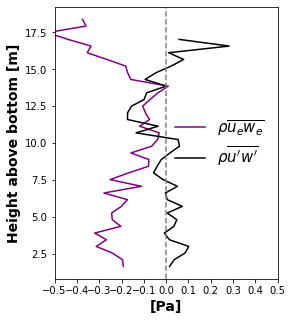

In [26]:
fnliw = 1800 # time index where t = 15th 03:30 h.

# Mask out Reynolds stress values that are smaller than the
# Williams & Simpson (2004) minimum measurable value.

spstd = 0.07 # Single-ping standard deviation [m/s]
theta = 25
M = t.size - fnliw
minRS = spstd**2/(np.sqrt(M)*np.sin(2*theta*d2r)) # Williams & Simpson (2004).
print("Smallest significant Reynolds stress: %.4f Pa"%(minRS*rho))

# Plot vertical profiles of <u_e*w_e> and <u'w'>. Compare averages over the NLIW event and over the entire record.
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(4, 5))
ax.set_xlim(-0.2, 0.2)
ax.plot(np.nanmean(uw[:, fnliw:], axis=1)*rho, z, 'purple', label=r"$\rho\overline{u_ew_e}$")
ax.plot(np.nanmean(uwdwb[:, fnliw:], axis=1)*rho, z, 'k', label=r"$\rho\overline{u'w'}$")
ax.axvline(color='gray', linestyle='dashed')
ax.legend(frameon=False, fontsize=15)
# xr = 0.2
xr = 0.5
ax.set_xlim(-xr, xr)
ax.xaxis.set_ticks(np.arange(-xr, xr + 0.1, 0.1))
ax.set_ylabel(r"Height above bottom [m]", fontsize=14, fontweight='black')
ax.set_xlabel(r"[Pa]", fontsize=14, fontweight='black')
fig.subplots_adjust(wspace=0.05)

In [27]:
fig.savefig("fig11.png", dpi=300, bbox_inches="tight")